## Build and Train model

Now let's see the code (implementation) step-by-step with description of theoretical aspect.

환경설정


In [1]:
!pip install -q torch torchvision numpy matplotlib tqdm

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import sys
folder_path = '/content/drive/MyDrive/Colab/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Working on {device}")

 Working on cuda


### 1. Load data

We load images (CIFAR-10) dataset and dataloader.<br>
Each batch has shape ```[batch_size, 3, 32 32]```.

We load images (CIFAR-10) dataset and dataloader.<br>
Each batch has shape ```[batch_size, 3, 32 32]```.

In [2]:
import torch
from torchvision import datasets, transforms

batch_size = 128
dataset = datasets.CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


### 2. Define noise scheduling

#### 2-1. noise scheduling
1. DDPM defines $\beta_t$.
2. $\alpha_t = 1 - \beta_t$.
3. $\bar\alpha_t = \prod_{s=1}^t \alpha_s$

In [1]:
T = 1000
betas = (1 - torch.linspace(start=0.9999, end=0.98, steps=T, dtype=torch.float)).view(-1,1,1,1).to(device)

# FILL
alphas = #FILL
alpha_bars = #FILL # use torch.cumprod
sqrt_alpha_bars = #FILL # use torch.sqrt
sqrt_one_minus_alpha_bars = #FILL # use torch.sqrt

SyntaxError: invalid syntax (1257725247.py, line 5)

#### 2-2. Forward process 

$\mathbf{x}_t = \sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\epsilon$

In [ ]:
def add_noise(x_0, epsilon, t):
    
    x_t = #FILL 

    return x_t

Visualization of forward diffusion process

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4140182..4.058587].


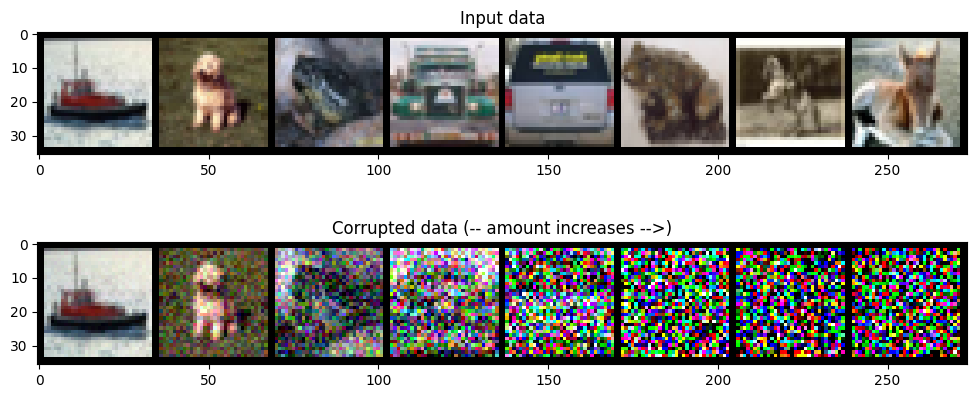

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy

x_0, _ = next(iter(loader))
x_0 = x_0[:8].to(device)

# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x_0).permute(1, 2, 0).cpu().numpy())

# Adding noise
t = torch.tensor([0, 25, 50, 100, 200, 400, 800, 999]).to(device)
epsilon = torch.randn_like(x_0).to(device)
x_t = add_noise(x_0, epsilon=epsilon, t=t)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(x_t).permute(1, 2, 0).cpu().numpy())

### 3. Train (Optimize) $\epsilon_{\theta}$

Now let's train $\epsilon_{\theta}$ (i.e, above U-Net).

1. Initialize $T$ and $\alpha_t$ ($t=1,\ldots,T$)
2. Pick up $\mathbf{x}_0$ in training set.
3. Pick up timestep $t$, such as $t \sim \verb|Uniform|(\{1,\ldots,T\})$
4. Generate the seed of noise $\epsilon$, such as $\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I})$
5. Compute $\mathbf{x}_t = \sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\epsilon$
6. Take the gradient descent step on $\nabla_{\theta} \| \epsilon - \epsilon_{\theta}(\mathbf{x}_t, t) \|^2$
7. Repeat 2 - 6 until convergence


In [ ]:
import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
from model import UNet

unet = UNet(
    source_channel=3,
    unet_base_channel=128,
    num_norm_groups=32,
).to(device)

# initialize optimizer
opt = torch.optim.Adam(unet.parameters(), lr=2e-4, eps=1e-08)
scheduler = torch.optim.lr_scheduler.LinearLR(
    opt,
    start_factor=1.0/5000,
    end_factor=1.0,
    total_iters=5000)

# train loop
num_epochs = 2
for epoch_idx in range(num_epochs):

    epoch_loss = []
    for batch_idx, (data, _) in enumerate(loader):
        unet.train()
        opt.zero_grad()

        # 1. Pick up x_0 (shape: [batch_size, 3, 32, 32])
        x_0 = data.to(device)
        b = x_0.shape[0]

        # 2. add noise to x_0
        epsilon = #FILL
        t = #FILL
        x_t = #FILL

        # 3. Get loss
        model_out = #FILL
        loss = F.mse_loss(#FILL, #FILL, reduction="mean")

        # 4. Gradient descent
        loss.backward()
        opt.step()
        scheduler.step()

        # log
        epoch_loss.append(loss.item())
        print("epoch{} (iter{}) - loss {:5.4f}\n".format(epoch_idx+1, batch_idx+1, loss), end="\r")

        # run this if you want to check whether the code runs properly
        # if batch_idx == 10:
        #   break
            
    # finalize epoch (save log and checkpoint)
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print("epoch{} (iter{}) - loss {:5.4f}\n".format(epoch_idx+1, batch_idx+1, epoch_average_loss))

    # torch.save(unet.state_dict(), f"ddpm_unet_{epoch_idx}.pt")

print("Done")

epoch1 (iter1) - loss 1.1180
epoch1 (iter2) - loss 1.1201
epoch1 (iter3) - loss 1.1190
epoch1 (iter4) - loss 1.1224
epoch1 (iter5) - loss 1.1181
epoch1 (iter6) - loss 1.1196
epoch1 (iter7) - loss 1.1161
epoch1 (iter8) - loss 1.1193
epoch1 (iter9) - loss 1.1130
epoch1 (iter10) - loss 1.1124
epoch1 (iter11) - loss 1.1127
epoch1 (iter11) - loss 1.1173

epoch2 (iter1) - loss 1.1075
epoch2 (iter2) - loss 1.1076
epoch2 (iter3) - loss 1.1022
epoch2 (iter4) - loss 1.1041
epoch2 (iter5) - loss 1.0997
epoch2 (iter6) - loss 1.0992
epoch2 (iter7) - loss 1.0981
epoch2 (iter8) - loss 1.0989
epoch2 (iter9) - loss 1.0887
epoch2 (iter10) - loss 1.0940
epoch2 (iter11) - loss 1.0846
epoch2 (iter11) - loss 1.0986

Done


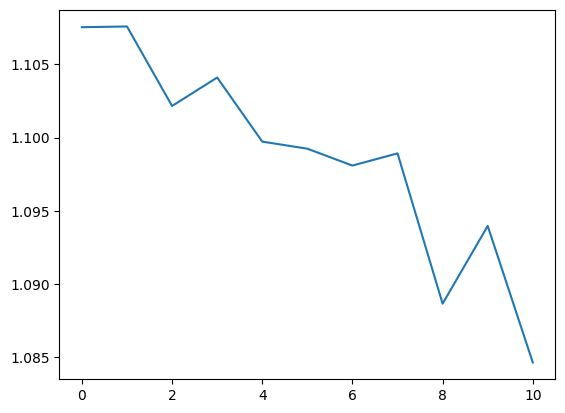

In [7]:
# If loss is decreasing, the model is properly trained
plt.plot(epoch_loss)

In [ ]:
# As we do not have enough time to train, load pretrained model.

# load pretrained diffusion models
if device.type == 'cpu':
  state_dict = torch.load("/content/drive/MyDrive/Colab/ddpm_unet_500.pt", map_location=torch.device('cpu'))
else:
  state_dict = torch.load("/content/drive/MyDrive/Colab/ddpm_unet_500.pt")

unet_pre = UNet(
    source_channel=3,
    unet_base_channel=128,
    num_norm_groups=32,
).to(device)

unet_pre.load_state_dict(state_dict)
unet_pre.eval()

print("successfully loaded")

successfully loaded


#### 3-2. Denoised output visualization

We plot $\mathbf{\hat x_0} = (\mathbf{x}_t - \sqrt{1 - \bar\alpha_t} \epsilon_\theta(\mathbf{x}_t,t))/\sqrt{\bar\alpha_t}$ along with $\mathbf{x}_0$ and $\mathbf{x}_t$.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7418933..3.6849282].


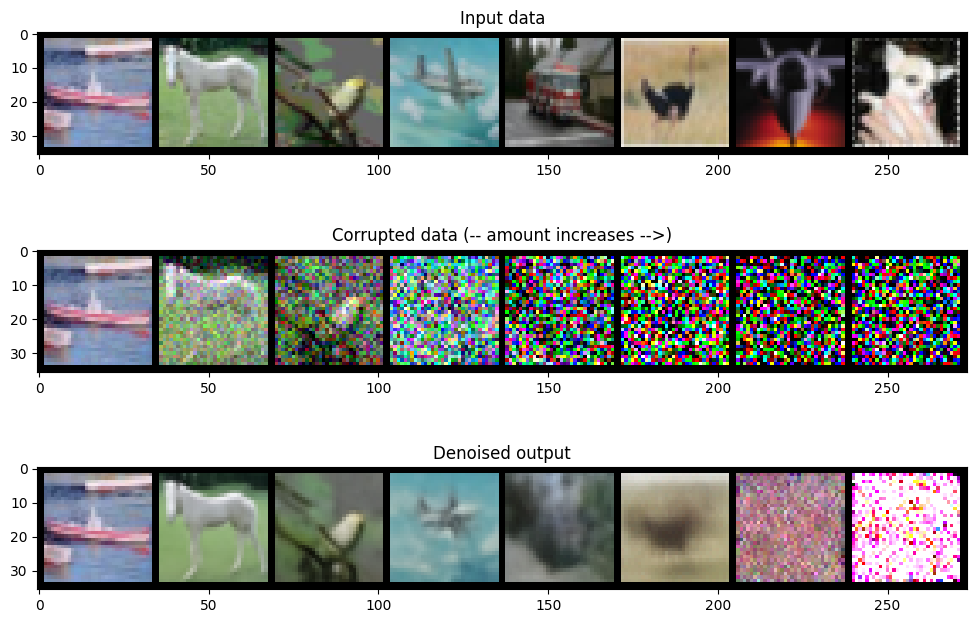

In [9]:
# Input data
x_0, _ = next(iter(loader))
x_0 = x_0[:8].to(device)
# Plotting the input data
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x_0).permute(1, 2, 0).cpu().numpy())

# Adding noise
t = torch.tensor([0, 25, 50, 100, 200, 400, 800, 999]).to(device)
epsilon = torch.randn_like(x_0).to(device)
x_t = add_noise(x_0, epsilon=epsilon, t=t)
# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(x_t).permute(1, 2, 0).cpu().numpy())

# Denoised output
epsilon_pred = #FILL
denoised_x = #FILL
denoised_x = torch.clamp(denoised_x, min=0.0, max=1.0)

# Plotting the denoised version
axs[2].set_title('Denoised output')
axs[2].imshow(torchvision.utils.make_grid(denoised_x).permute(1, 2, 0).cpu().numpy())


#### 4-1. Image generation with trained model : DDPM Sampling
Now let's create images using above trained model (U-Net).

As I have mentioned above, the image is generated by the following procedure.

1. Pick up white noise $\mathbf{x}_T$, such as, $\mathbf{x}_T \sim N(\mathbf{0},\mathbf{I})$
2. Loop the below procedure for $t=T,\ldots,1$
    - Pick up $\mathbf{z}$, such as, $\mathbf{z} \sim N(\mathbf{0},\mathbf{I})$ when $t>1$, $\mathbf{z} = \mathbf{0}$ otherwise
    - $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t,t) \right) + \sigma_t \mathbf{z}$ , where $\sigma_t^2 = \frac{(1-\alpha_t)(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_t}$
3. The obtained (generated) $\mathbf{x}_0$ will become the final image without noise.

I note that each step number in the comment (below) is corresponding to above number.

> Note : As you could see here, the generation process in DDPM is very slow, because the reverse diffusion process needs a large number of denoising iterations.<br>

In [10]:
def draw(images, num_row, num_col):
    fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
    for i in range(num_row*num_col):
        image = images[i].cpu().numpy()
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(image)

100%|██████████| 1000/1000 [01:02<00:00, 16.07it/s]


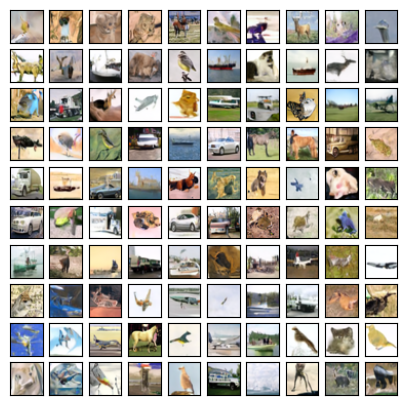

In [11]:
def ddpm_sample(unet, num_images):
    
    unet.eval()
    
    # 0. generate sigma_t
    alpha_bars_prev = torch.cat((torch.ones(1,1,1,1).to(device), alpha_bars[:-1]))
    sigma_t_squared = #FILL
    sigma_t = #FILL
    
    # 1. make white noise
    x = #FILL
    
    # 2. loop
    #   (t == 0 means diffused for 1 step)
    with torch.no_grad():
        for t in tqdm.tqdm(reversed(range(T)), total=T):
            if t > 0:
                z = #FILL sample normal noise
            else:
                z = #FILL 0 tensor
            t_batch = (torch.tensor(t).to(device)).repeat(num_images)
            epsilon = #FILL
            x = #FILL

    # reshape to channels-last : (N,C,H,W) --> (N,H,W,C)
    x = x.permute(0, 2, 3, 1)
    x = torch.clamp(x, min=0.0, max=1.0)

    return x

# generate and draw
num_row = 10
num_col = 10
generated_images = ddpm_sample(unet_pre, num_row*num_col)
draw(generated_images, num_row, num_col)

#### 4-2. DDIM Sampling 
[DDIM](https://arxiv.org/pdf/2010.02502) (Denoising Diffusion Implicit Models) is an invention to reduce the number of iterations required by the generative model, by transforming Markovian diffusion process to non-Markovian.

The image is generated by the following procedure:

1.  Pick up white noise $\mathbf{x}_T$, such as, $\mathbf{x}_T \sim N(\mathbf{0},\mathbf{I})$.

2.  Choose a subsequence of timesteps (e.g., 50 steps from `T` down to 1) and loop through them. For each timestep `t` in the subsequence:
    -   First, predict the "denoised" image $\hat{\mathbf{x}}_0$ using the model's output $\epsilon_{\theta}(\mathbf{x}_t,t)$:
        $$ \hat{\mathbf{x}}_0 = \frac{1}{\sqrt{\overline{\alpha}_t}} \left( \mathbf{x}_t - \sqrt{1-\overline{\alpha}_t} \cdot \epsilon_{\theta}(\mathbf{x}_t,t) \right) $$
    -   Then, compute the next step $\mathbf{x}_{t-1}$ using the predicted $\hat{\mathbf{x}}_0$. The amount of randomness is controlled by a parameter $\eta$ (eta).
        $$ \mathbf{x}_{t-1} = \sqrt{\overline{\alpha}_{t-1}} \hat{\mathbf{x}}_0 + \sqrt{1-\overline{\alpha}_{t-1}-\sigma_t^2} \cdot \epsilon_{\theta}(\mathbf{x}_t,t) + \sigma_t \mathbf{z} $$ for $\sigma_t = \eta * \sqrt{\frac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t} (1- \frac{\bar\alpha_t}{\bar\alpha_{t-1}})}$. ($\alpha_t$ in DDIM paper is equivalent to $\bar\alpha_t$ in DDPM)
        - When $\eta=0$, the process is deterministic and $\sigma_t=0$.
        - When $\eta=1$, the process is equivalent to DDPM.

3.  The final image is obtained from the last step of the loop.

In [12]:
import torch
import tqdm
import matplotlib.pyplot as plt

def ddim_sample(unet, num_images, num_steps=50, eta=0.0):
    """
    Parameters:
    - num_steps: 샘플링 스텝 수 (클수록 품질이 좋아지지만 오래 걸림)
    - eta: 0이면 결정론적(deterministic), 1이면 DDPM과 동일한 확률적(stochastic) 샘플링
    """
    unet.eval()
    
    # 0. Generate timesteps for sampling (e.g., [999, 979, 959, ..., 0])
    timesteps = #FILL
    print(f"DDIM sampe timesteps: {timesteps.cpu().numpy()}")
    
    with torch.no_grad():
        # 1. make white noise
        x = #FILL

        # 2. DDIM sampling loop
        for i, t in tqdm.tqdm(enumerate(timesteps), total=num_steps, desc="DDIM Sampling"):
            
            # 현재 타임스텝과 이전 타임스텝 준비
            time_tensor = t.repeat(num_images)
            prev_t = timesteps[i + 1] if i < num_steps - 1 else torch.tensor(-1, device=device)

            # alpha_bar 값들을 가져옴
            alpha_bar_t = #FILL
            alpha_bar_t_prev = #FILL

            # 3-1. 모델을 사용해 노이즈(epsilon) 예측
            epsilon = #FILL

            # 3-2. DDIM 공식을 사용해 x_{t-1} 계산
            # 원본 이미지(x_0) 예측
            pred_x0 = #FILL

            # DDIM의 sigma_t 계산 (eta에 따라 달라짐)
            sigma_t = #FILL

            # x_{t-1}의 방향을 결정하는 노이즈 예측 (두번쨰 텀)
            pred_dir_xt = #FILL 

            # 최종 x_{t-1} 계산
            x_prev = #FILL
            
            # eta가 0보다 크면 추가 노이즈 주입
            if eta > 0:
                x_prev += #FILL

            x = x_prev

    # 후처리
    x = x.permute(0, 2, 3, 1) # (N,C,H,W) -> (N,H,W,C) for plotting
    x = torch.clamp(x, min=0.0, max=1.0) # 값의 범위를 [0, 1]로 맞춤

    return x

DDIM sampe timesteps: [999 888 777 666 555 444 333 222 111   0]


DDIM Sampling: 100%|██████████| 10/10 [00:00<00:00, 17.36it/s]


DDIM sampe timesteps: [999 888 777 666 555 444 333 222 111   0]


DDIM Sampling: 100%|██████████| 10/10 [00:00<00:00, 17.50it/s]


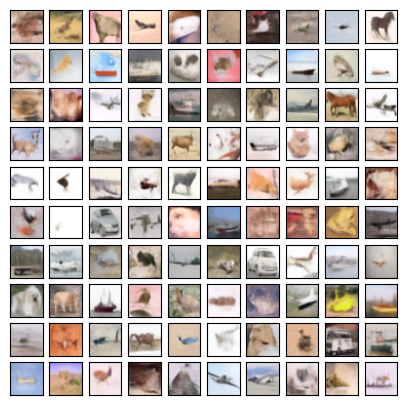

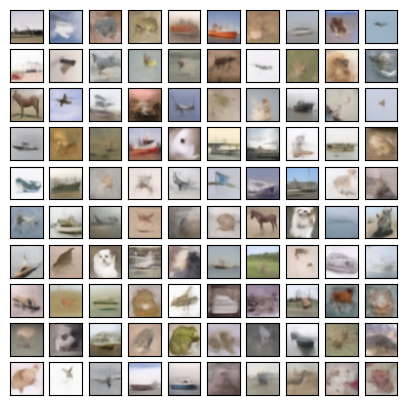

In [13]:
# Test
num_row = 10
num_col = 10
generated_images = ddim_sample(unet_pre, num_row * num_col, num_steps=10, eta=0.0)
draw(generated_images, num_row, num_col)

num_row = 10
num_col = 10
generated_images = ddim_sample(unet_pre, num_row * num_col, num_steps=10, eta=1.0)
draw(generated_images, num_row, num_col)